## Predicting Survival on the Titanic using Logistic Regression

This week we will be building a logistic regression classifier to predict survival on the titanic.   

My model will use the independent variables sex and age to predict the dependent variable survived.  There are many other variables in the dataset that you could and should use, that will be your assignment for the week.   (More on that later)

###Data Prep
First, I will start with some data prep to get my data ready to be used in a model

In [74]:
import pandas as pd
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [75]:
#reading the data from the disk into memory
df = pd.read_csv("train.csv")

In [76]:
#Just a reminder, here are all the column names
df.columns

Index([u'PassengerId', u'Survived', u'Pclass', u'Name', u'Sex', u'Age',
       u'SibSp', u'Parch', u'Ticket', u'Fare', u'Cabin', u'Embarked'],
      dtype='object')

In [77]:
#I'm going to create a new dataframe and put only the three variables I'm going to be using into it.
X = pd.DataFrame()
X['sex'] = df['Sex']
X['age'] = df['Age']
X['survived'] = df['Survived']

In [78]:
#I'm going to drop missing values.   That's probably NOT the best strategy, but it's usually good to start simple and 
#build complexity as you go.
X = X.dropna(axis=0)

In [79]:
#survived will be my dependent variable, y.   I'll assign it to y and remove it from X
y = X['survived']
X = X.drop(['survived'], axis=1)

In [80]:
# We need to handle Sex such that it's categorical, for logistic regression.
# Currently it's a string
#refer back to last week's lecture if you forget why we're doing this

#We can use pandas get_dummies to implement one hot encoding.
pd.get_dummies(X.sex)

,female,male
0,0,1
1,1,0
2,1,0
3,1,0
4,0,1
6,0,1
7,0,1
8,1,0
9,1,0
10,1,0


In [81]:
#IMPORTANT! get_dummies returns an indicator variable for each category.
#Refering back to my talk on encoding variables, it's important to drop one category
#Otherwise you'll have two perfectly colinear variables.   

#Here, since I only have two variables it's easy, I'll just take one, and reassign it to sex
#so now Sex becomes female = 1, male = 0
X['sex'] = pd.get_dummies(X.sex)['female']

In [82]:
#remember to scale our features, as with linear regression
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X= scaler.fit_transform(X)

In [83]:
#build test and training sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Model Creation
At this point I have a test and train set defined.  I will use train to train my model and test to see how accurate the model is.

There's one problem with that though.   Lets say my model is right 70% of the time.   Is that good?  Maybe?   

I'm going to build a simple 'base rate' model to compare my logistic model to, so we can see if our logistic model is useful or not.  

Then, I'll build my logistic model.


####Base Rate Model
For my baserate model, I'm going to predict that everyone dies.

In [84]:
#This function looks for females in the test set and returns 1, survived, otherwise it returns 0
def base_rate_model(X):
    y = np.zeros(X.shape[0])
    return y
    

In [85]:
#how accurate is my base rate model?
y_base_rate = base_rate_model(X_test)
from sklearn.metrics import accuracy_score
print "Base rate accuracy is %2.2f" % accuracy_score(y_test, y_base_rate)

Base rate accuracy is 0.61


So, our base model is 61% correct, lets see if logistic can beat it.

In [86]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(penalty='l2', C=1)

In [87]:
model.fit(X_train, y_train)

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0)

In [88]:
print "Logistic accuracy is %2.2f" % accuracy_score(y_test,model.predict(X_test))

Logistic accuracy is 0.73


### Model Comparison

Our base model wasn't very good, but it looked better than it was because of class imbalance.  There are many more 0s than 1s in our dataset, so if we just guess 0 we can 'cheat.'

A better metric for binary classifer comparisons is AUC or area under the curve. 

Closely related is [precision and recall](http://scikit-learn.org/stable/auto_examples/plot_precision_recall.html).

Precision is the fraction of correctly identified examples of a class (ratio of true positives to all positives).

Recall is the fraction of observastions classified in that class that was correctly classified.  

Think of fishing with a net for tuna.   
*  If our net is very precise, and has high recall it will catch any and all tuna and ONLY tuna.
*  If our net is very precise, but has low recall then we might catch one tuna, but most will escape.
*  If our net is low precision, but has high recall, then we might catch tuna, but also any other fish around
*  If our net is low precision, and low recall, then we should probably give up fishing.   


In [89]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report



In [90]:
print "---Base Model---"
#base rate AUC
base_roc_auc = roc_auc_score(y_test, base_rate_model(X_test))
print "Base Rate AUC = %2.2f" % base_roc_auc
print classification_report(y_test,base_rate_model(X_test) )
print "\n\n---Logistic Model---"
#logistic AUC
logit_roc_auc = roc_auc_score(y_test, model.predict(X_test))
print "Logistic AUC = %2.2f" % logit_roc_auc
print classification_report(y_test, model.predict(X_test) )

---Base Model---
Base Rate AUC = 0.50
             precision    recall  f1-score   support

          0       0.61      1.00      0.76        87
          1       0.00      0.00      0.00        56

avg / total       0.37      0.61      0.46       143



---Logistic Model---
Logistic AUC = 0.72
             precision    recall  f1-score   support

          0       0.78      0.79      0.78        87
          1       0.67      0.64      0.65        56

avg / total       0.73      0.73      0.73       143



In [91]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])

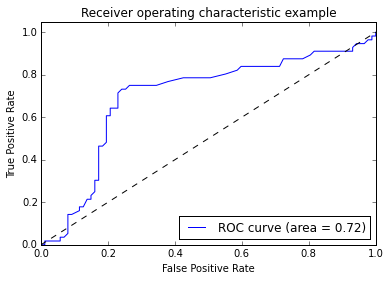

In [92]:
# Plot of a ROC curve for a specific class
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

### My Turn now.

In [93]:
X = pd.DataFrame()
X['sex'] = df['Sex']
X['age'] = df['Age']
X['sibsp'] = df['SibSp']
X['parch'] = df['Parch']
X['pclass'] = df['Pclass']
X['survived'] = df['Survived']

In [94]:
X

,sex,age,sibsp,parch,pclass,survived
0,male,22,1,0,3,0
1,female,38,1,0,1,1
2,female,26,0,0,3,1
3,female,35,1,0,1,1
4,male,35,0,0,3,0
5,male,NaN,0,0,3,0
6,male,54,0,0,1,0
7,male,2,3,1,3,0
8,female,27,0,2,3,1
9,female,14,1,0,2,1


In [95]:
X['sex'] = pd.get_dummies(X.sex)['female']

In [96]:
X

,sex,age,sibsp,parch,pclass,survived
0,0,22,1,0,3,0
1,1,38,1,0,1,1
2,1,26,0,0,3,1
3,1,35,1,0,1,1
4,0,35,0,0,3,0
5,0,NaN,0,0,3,0
6,0,54,0,0,1,0
7,0,2,3,1,3,0
8,1,27,0,2,3,1
9,1,14,1,0,2,1


In [97]:
X.age.describe()

count    714.000000
mean      29.699118
std       14.526497
min        0.420000
25%       20.125000
50%       28.000000
75%       38.000000
max       80.000000
Name: age, dtype: float64

In [98]:
X[X.age.isnull()]

,sex,age,sibsp,parch,pclass,survived
5,0,NaN,0,0,3,0
17,0,NaN,0,0,2,1
19,1,NaN,0,0,3,1
26,0,NaN,0,0,3,0
28,1,NaN,0,0,3,1
29,0,NaN,0,0,3,0
31,1,NaN,1,0,1,1
32,1,NaN,0,0,3,1
36,0,NaN,0,0,3,1
42,0,NaN,0,0,3,0


In [99]:
meanAge = X.age.mean()

In [100]:
X['age'] = X['age'].fillna(meanAge + (10 * np.random.random_sample()))

In [101]:
X[X.age.isnull()]

,sex,age,sibsp,parch,pclass,survived


In [102]:
X.age.describe()

count    891.000000
mean      31.132952
std       13.317467
min        0.420000
25%       22.000000
50%       32.000000
75%       36.916895
max       80.000000
Name: age, dtype: float64

In [103]:
y = X['survived']
X = X.drop(['survived'], axis=1)

In [104]:
scaler = StandardScaler()
X= scaler.fit_transform(X)

In [105]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [107]:
model = LogisticRegression(penalty='l2', C=10)

In [108]:
model.fit(X_train, y_train)

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0)

In [109]:
print "Logistic accuracy is %2.2f" % accuracy_score(y_test,model.predict(X_test))

Logistic accuracy is 0.82


In [110]:
print "\n\n---Logistic Model---"
logit_roc_auc = roc_auc_score(y_test, model.predict(X_test))
print "Logistic AUC = %2.2f" % logit_roc_auc
print classification_report(y_test, model.predict(X_test) )



---Logistic Model---
Logistic AUC = 0.80
             precision    recall  f1-score   support

          0       0.83      0.87      0.85       105
          1       0.80      0.74      0.77        74

avg / total       0.81      0.82      0.81       179



In [111]:
fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:,1])

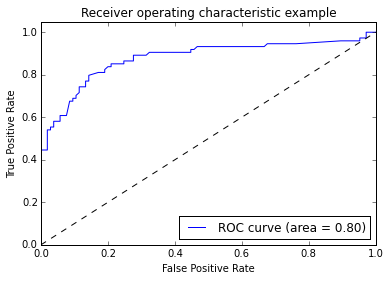

In [112]:
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % logit_roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()